In [354]:
import os
# os.chdir('tcr-covid-classifier')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import multipy

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, \
                            plot_clonotype_clustering_with_epitope_labeling, plot_cooccurence_heatmap_with_epitopes_labeling_bubble
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence
from utils.weblogo_utils import create_web_logo
from math import sqrt


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.clustering_utils")
importlib.reload(imported_module)

<module 'utils.clustering_utils' from '/home/ekvlasova/tcr-covid-classifier/utils/clustering_utils.py'>

In [355]:
os.getcwd()

'/home/ekvlasova/tcr-covid-classifier'

In [285]:
adaptive = pd.read_csv('data/covid_significant_clone_pvals_adaptive.csv')

<AxesSubplot:>

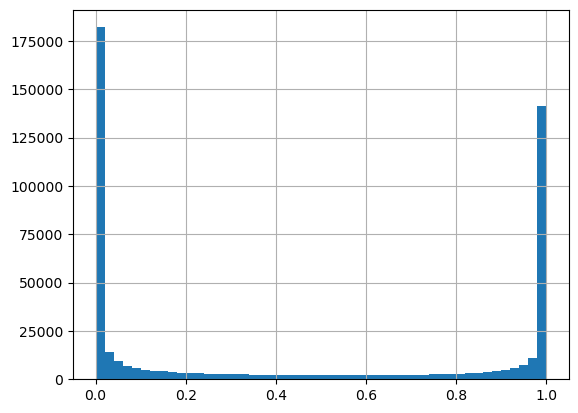

In [288]:
adaptive.pval.hist(bins=50)

In [284]:
pd.read_csv('data/covid_significant_clones_adaptive.csv')

,clone
0,CASSPGQGNQPQHF
1,CASSLAGGTDTQYF
2,CASSLGGSTDTQYF
3,CASSLSGNTIYF
4,CASSLGYGYTF
...,...
68717,CASSMDRVSGNTIYF
68718,CASSLNGGSQPQHF
68719,CASSRWGSGNTIYF
68720,CASSQPSGYGYTF


<AxesSubplot:>

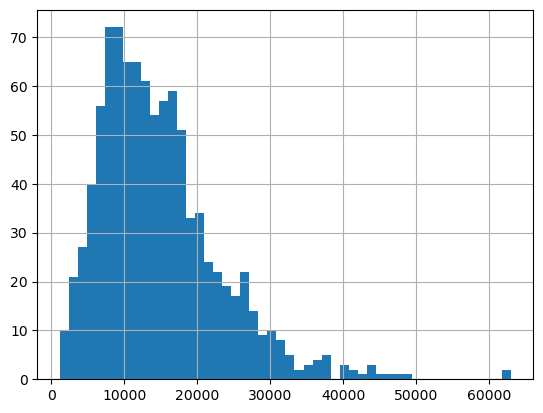

In [267]:
pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv').number_of_clones.hist(bins=50)

<AxesSubplot:>

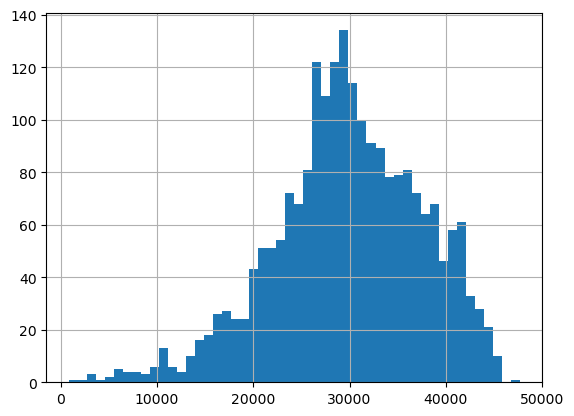

In [268]:
pd.read_csv('data/run_to_number_of_clones_adaptive.csv').number_of_clones.hist(bins=50)

In [2]:
os.getcwd()

'/home/ekvlasova/tcr-covid-classifier'

In [ ]:
pd.read_csv()

In [17]:
df = pd.read_csv('data/adaptive_new.txt', sep='\t')

In [20]:
df['file_name'] = df.sample_name + '.tsv.txt'

In [21]:
df['covid'] = 'covid'

In [22]:
df.to_csv('data/adaptive_new.csv', index=False)

In [71]:
# os.chdir('ekvlasova/tcr-covid-classifier')

In [21]:
old_beta = pd.read_csv('notebooks/old_beta.csv').drop(columns=['Unnamed: 0']).rename(columns={'0': 'cdr3aa'})

In [22]:
old_beta

,cdr3aa
0,CASSLGYEQYF
1,CASSLGGNQPQHF
2,CASSLGSNQPQHF
3,CASSLTGNTEAFF
4,CASSSSYEQYF
...,...
305,CASSQKGYEQYF
306,CASSMDRGYEQYF
307,CASRRTYEQYF
308,CASSRGWEQYF


In [323]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [357]:
alpha_pvals = pd.read_csv('data/covid_significant_clone_pvals_fmba_TRA_top_500k.csv').drop(columns=['Unnamed: 0'])

In [358]:
beta_pvals = pd.read_csv('data/covid_significant_clone_pvals_fmba_TRB_top_500k.csv').drop(columns=['Unnamed: 0'])

In [359]:
beta_pvals

,clone,pval
0,CAAADYGYTF,0.268229
1,CAAAGANVLTF,0.032232
2,CAAAGDGNTIYF,0.451978
3,CAAAGGDTQYF,0.918696
4,CAAAGGNYGYTF,0.518237
...,...,...
930672,YSARFGGPNQPQHF,0.290290
930673,YSARQGNMGNQPQHF,0.885845
930674,YSASETNYGYTF,0.192210
930675,YSAWTEETQYF,0.884817


In [363]:
from multipy.fdr import lsu

beta_pvals[lsu(beta_pvals.pval, q=0.05)]

,clone,pval
1937,CAGSLGGSYEQYF,0.000003
7842,CAISEGTSGSYEQYF,0.000036
12061,CAISGQGVNTEAFF,0.000029
14931,CANSLGGSYEQYF,0.000007
17234,CASAPGGSYEQYF,0.000020
...,...,...
921169,CSVGLGYEQYF,0.000025
925084,CSVRTGGYEQYF,0.000015
927835,CVSSLGGSYEQYF,0.000038
928198,GASSLGGNQPQHF,0.000075


In [362]:
alpha_pvals[lsu(alpha_pvals.pval, q=0.05)]

,clone,pval
312,CAAADFNKFYF,3.111568e-04
354,CAAADNFNKFYF,1.396065e-08
607,CAAAFNKFYF,2.728978e-07
1685,CAAALYNFNKFYF,4.984361e-14
1732,CAAANAGNNRKLIW,8.425337e-05
...,...,...
1134429,RALSSGSARQLTF,4.610028e-07
1134542,RALYNFNKFYF,2.788332e-09
1138483,SALSSGGGADGLTF,3.270429e-04
1142371,YAALYNFNKFYF,1.606003e-09


In [303]:
fmba_b = pd.read_csv('data/standardized_usage_matrix_fmba_TRB.csv').drop(columns=['Unnamed: 0'])

In [302]:
adaptive_b = pd.read_csv('data/standardized_usage_matrix_adaptive.csv').drop(columns=['Unnamed: 0'])

In [307]:
merged = pd.concat([fmba_b, adaptive_b])
merged[['run', 'project', 'covid'] + [x for x in merged.columns if x.startswith('TRB')]].fillna(0)

,run,project,covid,TRBV5-8,TRBV6-5,TRBV5-6,TRBV12-4,TRBV13,TRBV7-9,TRBV7-1,...,TRBV5-1,TRBV11-3,TRBV7-5,TRBV7-8,TRBV6-1,TRBV1,TRBV5-2,TRBV22-1,TRBV8-2,TRBV26
0,020000010808_S3_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5,covid,0.011362,0.023325,0.007688,0.000532,0.004110,0.015303,7.523657e-07,...,0.092667,0.009706,0.001239,0.021796,0.057686,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,020000190808_S27_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5,covid,0.004046,0.045614,0.015801,0.000991,0.006816,0.053645,7.523657e-07,...,0.028359,0.008428,0.001607,0.016108,0.014549,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2,020000200808_S181_L002.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5,healthy,0.007933,0.065077,0.025857,0.000759,0.006533,0.044795,7.523657e-07,...,0.052100,0.006165,0.002132,0.006365,0.037227,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,020000280808_S59_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5,covid,0.003132,0.042770,0.029748,0.000860,0.001821,0.034645,7.523657e-07,...,0.036125,0.008234,0.001350,0.017567,0.041081,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,020000340808_S82_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5,covid,0.005687,0.017944,0.023716,0.000904,0.010007,0.044803,7.523657e-07,...,0.082581,0.013589,0.001457,0.011153,0.037883,0.000000,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,Keck0116_MC1.txt,KECK,healthy,0.002473,0.023580,0.021575,0.013692,0.005407,0.038632,1.575187e-05,...,0.047568,0.007180,0.000368,0.012993,0.018063,0.002751,0.000005,0.000013,0.000003,1.120349e-06
2196,Keck0117_MC1.txt,KECK,healthy,0.005521,0.049995,0.022142,0.052444,0.009407,0.027108,9.729150e-06,...,0.050037,0.010467,0.000787,0.016833,0.009894,0.001801,0.000002,0.000009,0.000003,1.246315e-06
2197,Keck0118_MC1.txt,KECK,healthy,0.002765,0.025162,0.020522,0.012569,0.006442,0.010505,1.413046e-05,...,0.037392,0.009141,0.000689,0.009371,0.008640,0.002138,0.000006,0.000011,0.000004,1.164193e-06
2198,Keck0119_MC1.txt,KECK,healthy,0.002976,0.046187,0.015239,0.033238,0.004477,0.032008,1.357222e-05,...,0.082719,0.004598,0.000221,0.013684,0.019597,0.001662,0.000006,0.000017,0.000001,1.137229e-06


In [293]:
beta_pvals[lsu(beta_pvals.pval, q=0.05)][['clone']].to_csv('data/covid_significant_clones_fmba_TRB_top_500k.csv', index=False)

In [294]:
alpha_pvals[lsu(alpha_pvals.pval, q=0.05)][['clone']].to_csv('data/covid_significant_clones_fmba_TRA_top_500k.csv', index=False)

In [141]:
beta_pvals[beta_pvals.pval < 1e-4][['clone']].to_csv('data/covid_significant_clones_fmba_TRB_top_500k.csv', index=False)

In [344]:
res_beta = seqs2hamming(beta_pvals[lsu(beta_pvals.pval, q=0.01)].clone, viz_method='graphopt')

In [345]:
res_beta

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CAGSLGGSYEQYF,0,40.299247,50.317858,1358,7.584728,-12.625548
1,CANSLGGSYEQYF,0,-144.527478,196.996414,1358,7.584728,-12.625548
2,CASSLGGSYEQYF,0,-51.026597,91.393691,1358,7.584728,-12.625548
3,CATSLGGSYEQYF,0,-134.900739,205.541616,1358,7.584728,-12.625548
4,CAWSLGGSYEQYF,0,10.090789,60.439779,1358,7.584728,-12.625548
...,...,...,...,...,...,...,...
4326,CSVGLGYEQYF,245,30.168235,-90.645411,1,30.168235,-90.645411
4327,CSVRDSSYEQYF,246,551.795592,-524.739371,1,551.795592,-524.739371
4328,CSVRGPYEQYF,247,-548.425410,-313.161375,1,-548.425410,-313.161375
4329,CSVRTGTYEQYF,248,50.317871,40.232925,1,50.317871,40.232925


In [ ]:
beta_cluster_to_epi = {}
for cluster_index in range(res_beta.cluster.max()):
    beta_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_beta, cluster_index, dist=1, gene='TRB', alpha=0.05)

In [ ]:
plot_clonotype_clustering_with_epitope_labeling(res_beta, 
                                                beta_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=650, 
                                                center_diff_threshold=75,
                                                )

plt.xlim(-700, 700)
plt.ylim(-700, 700)
plt.title('beta')
plt.legend().set_visible(False)

In [73]:
alpha_pvals[alpha_pvals.pval < 1e-4]

,clone,pval
354,CAAADNFNKFYF,9.144445e-09
607,CAAAFNKFYF,5.057810e-07
1685,CAAALYNFNKFYF,2.540847e-13
1732,CAAANAGNNRKLIW,7.172378e-05
1746,CAAANFNKFYF,3.867558e-24
...,...,...
1134227,RALSEAQGGSEKLVF,4.900306e-06
1134429,RALSSGSARQLTF,3.889343e-06
1134542,RALYNFNKFYF,1.493361e-10
1142371,YAALYNFNKFYF,1.922726e-09


In [328]:
res_alpha = seqs2hamming(alpha_pvals[lsu(alpha_pvals.pval, q=0.01)].clone, viz_method='drl')

In [329]:
res_alpha

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CAAADNFNKFYF,0,4.470227,54.560810,528,-38.480754,99.482314
1,CAAAYNFNKFYF,0,30.808228,62.858055,528,-38.480754,99.482314
2,CAAEDNFNKFYF,0,4.007835,54.416786,528,-38.480754,99.482314
3,CAAGDNFNKFYF,0,4.242477,53.628345,528,-38.480754,99.482314
4,CAAIDNFNKFYF,0,0.874977,54.863998,528,-38.480754,99.482314
...,...,...,...,...,...,...,...
2753,CVVRYDSWGKLQF,116,203.000427,277.426147,2,202.967957,277.690109
2754,CVVSEASGGYQKVTF,117,66.629799,-190.993698,2,66.779594,-191.214798
2755,CVVSEPSGGYQKVTF,117,66.929390,-191.435898,2,66.779594,-191.214798
2756,CVVSLSNTDKLIF,118,65.426704,316.586609,1,65.426704,316.586609


In [330]:
alpha_cluster_to_epi = {}
for cluster_index in range(res_alpha.cluster.max()):
    alpha_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_alpha, cluster_index, dist=1, gene='TRA', alpha=0.05)

LLLEWLAMA
FLNRFTTTL


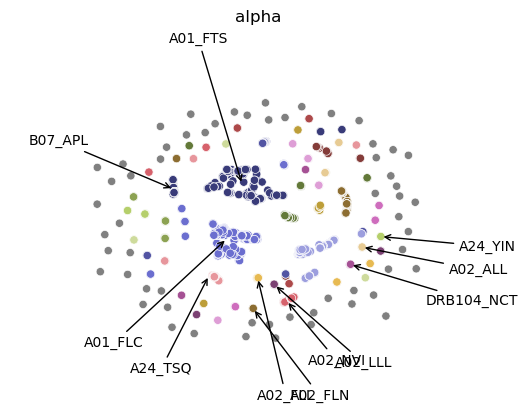

In [331]:
plot_clonotype_clustering_with_epitope_labeling(res_alpha, 
                                                alpha_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRA', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=500, 
                                                center_diff_threshold=75,
                                                )

plt.xlim(-600, 600)
plt.ylim(-600, 600)
plt.title('alpha')
plt.legend().set_visible(False)

In [192]:
for alpha_cluster in alpha_cluster_to_epi.keys():
    for beta_cluster in beta_cluster_to_epi.keys():
        if alpha_cluster_to_epi[alpha_cluster] is not None and beta_cluster_to_epi[beta_cluster] is not None and len(
            alpha_cluster_to_epi[alpha_cluster][['antigen.epitope']].merge(beta_cluster_to_epi[beta_cluster][['antigen.epitope']])) > 0:
            
            print(alpha_cluster, beta_cluster)
            print(alpha_cluster_to_epi[alpha_cluster][['antigen.epitope', 'antigen.species']].merge(
                beta_cluster_to_epi[beta_cluster][['antigen.epitope', 'antigen.species']]))

0 6
  antigen.epitope antigen.species
0       FTSDYYQLY      SARS-CoV-2
2 6
  antigen.epitope antigen.species
0   PKYVKQNTLKLAT      InfluenzaA
3 2
  antigen.epitope antigen.species
0       LLWNGPMAV             YFV
9 0
   antigen.epitope antigen.species
0  PGVLLKEFTVSGNIL     HomoSapiens
30 1
  antigen.epitope antigen.species
0       LTDEMIAQY      SARS-CoV-2
30 6
  antigen.epitope antigen.species
0       LTDEMIAQY      SARS-CoV-2
115 2
  antigen.epitope antigen.species
0       YVDNSSLTI      SARS-CoV-2


In [21]:
pd.read_csv('data/cluster_presence_matrix_TRB.csv')

,Unnamed: 0,run,TRB_cluster_0,TRB_cluster_1,TRB_cluster_2,TRB_cluster_3,TRB_cluster_4,TRB_cluster_5,TRB_cluster_6,TRB_cluster_7,...,TRB_cluster_71,TRB_cluster_72,TRB_cluster_73,TRB_cluster_74,TRB_cluster_75,TRB_cluster_76,TRB_cluster_77,TRB_cluster_78,TRB_cluster_79,TRB_cluster_80
0,0,020000010808_S3_L001,0,0,1,1,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,1,020000360808_S102_L002,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,2,020000700808_S134_L002,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
3,3,050002090808_S74_L001,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
4,4,020003890808_S67_L001,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,951,640003490808_S58_L001,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
952,952,640002310808_S7_L001,0,1,1,1,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
953,953,640002920808_S23_L001,0,1,1,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
954,954,780003220808_S28_L001,0,1,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0


In [96]:
cooccurence_df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,0.001248,0.001196,0.001061,0.001161,0.001212,0.001054,0.001046,0.001389,0.001107,0.001190,...,0.001276,0.000821,0.001055,0.001701,0.001201,0.000882,0.001404,0.001253,0.002480,0.001244
1,0.001044,0.001046,0.001047,0.001044,0.001048,0.001046,0.001046,0.001045,0.001051,0.001057,...,0.001057,0.001057,0.001057,0.001057,0.001057,0.001057,0.001051,0.001057,0.001057,0.001054
2,0.001046,0.001046,0.001046,0.001046,0.001046,0.001046,0.001046,0.001046,0.001046,0.001046,...,0.001046,0.001046,0.001046,0.001046,0.001046,0.001046,0.001046,0.001046,0.001046,0.001046
3,0.001152,0.001256,0.001073,0.001173,0.001228,0.001047,0.001046,0.001175,0.001155,0.000962,...,0.001276,0.001768,0.001095,0.001425,0.001382,0.001128,0.001260,0.001181,0.001736,0.001177
4,0.001180,0.001196,0.001061,0.001187,0.001267,0.001039,0.001046,0.001362,0.001146,0.001222,...,0.001116,0.000663,0.001308,0.001068,0.001433,0.001335,0.001269,0.001350,0.001202,0.001236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.001243,0.001022,0.001059,0.001240,0.001116,0.001045,0.001046,0.001365,0.000887,0.000953,...,0.001124,0.000877,0.001395,0.001211,0.001477,0.001491,0.001476,0.001041,0.001059,0.001341
77,0.001246,0.001274,0.001056,0.001298,0.001318,0.001044,0.001046,0.001196,0.001391,0.000957,...,0.001147,0.000825,0.001211,0.001519,0.001207,0.001196,0.001263,0.001259,0.001196,0.001216
78,0.001080,0.001153,0.001025,0.001125,0.001031,0.001036,0.001046,0.001321,0.001239,0.001400,...,0.001171,0.001555,0.001245,0.001041,0.001128,0.001290,0.001289,0.001222,0.001366,0.001227
79,0.001364,0.001284,0.001063,0.001355,0.001364,0.001054,0.001046,0.001543,0.001227,0.001065,...,0.001105,0.000575,0.001336,0.001058,0.001427,0.001132,0.001436,0.001462,0.001389,0.001255


In [87]:
pd.read_csv('data/TRA_TRB_cooccurence_matrix_cooccurence_85.csv').T

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.592593,0.0,0.0,0.406061,0.366071,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.574074,0.0,0.0,0.375758,0.339286,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
cooccurence_df = pd.read_csv('data/TRA_TRB_cooccurence_matrix_cooccurence_75.csv').drop(columns=['Unnamed: 0'])
annot_df = pd.read_csv('data/alpha_beta_paired_epitopes.csv').T

In [24]:
beta_cluster_presence = pd.read_csv('data/cluster_presence_matrix_TRB.csv').drop(columns=['Unnamed: 0'])

In [25]:
alpha_cluster_presence = pd.read_csv('data/cluster_presence_matrix_TRA.csv').drop(columns=['Unnamed: 0'])

In [26]:
beta_cluster_presence

,run,TRB_cluster_0,TRB_cluster_1,TRB_cluster_2,TRB_cluster_3,TRB_cluster_4,TRB_cluster_5,TRB_cluster_6,TRB_cluster_7,TRB_cluster_8,...,TRB_cluster_71,TRB_cluster_72,TRB_cluster_73,TRB_cluster_74,TRB_cluster_75,TRB_cluster_76,TRB_cluster_77,TRB_cluster_78,TRB_cluster_79,TRB_cluster_80
0,020000010808_S3_L001,0,0,1,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,020000360808_S102_L002,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,020000700808_S134_L002,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
3,050002090808_S74_L001,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,1,0
4,020003890808_S67_L001,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,640003490808_S58_L001,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
952,640002310808_S7_L001,0,1,1,1,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
953,640002920808_S23_L001,0,1,1,0,0,0,0,1,1,...,0,0,0,1,0,0,0,1,0,0
954,780003220808_S28_L001,0,1,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0


In [208]:
def evaluate_value_for_alpha_beta(alpha, beta):
    beta_ind = f'TRB_cluster_{beta}'
    alpha_ind = f'TRA_cluster_{alpha}'
    df = beta_cluster_presence[['run', beta_ind]].merge(
            alpha_cluster_presence[['run', alpha_ind]]).drop(
                columns=['run'])
    df['joint'] = df.apply(lambda x: 1 if x[beta_ind] + x[alpha_ind] == 2 else 0, axis=1)
    return df['joint'].sum() / (df[beta_ind].sum() + df[alpha_ind].sum())

In [209]:
from tqdm import tqdm 

In [210]:
coocc_dict = {}
for i in tqdm(range(cooccurence_df.columns.max() + 1)):
    values = []
    for j in range(len(cooccurence_df)):
        values.append(evaluate_value_for_alpha_beta(alpha=i, beta=j))
    coocc_dict[i] = pd.Series(values)

100%|██████████| 260/260 [05:12<00:00,  1.20s/it]


In [211]:
cooccurence_df = pd.DataFrame.from_dict(coocc_dict)

In [212]:
cooccurence_df.to_csv('data/TRA_TRB_cooccurence_matrix_cooccurence_75.csv', index=False)

In [104]:
annot_df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
annot_df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import PatchCollection

In [223]:
np.quantile(cooccurence_df.to_numpy().flatten(), 0.95)

0.33732697343808443

In [226]:
(cooccurence_df.max() > 0.44).sum()

33

In [238]:
def plot_cooccurence_heatmap_with_epitopes_labeling_bubble(plotting_df, annot_df, fig=None, ax=None,
                                                           epitopes_count_threshold=0, corr_threshold_row=0.1,  
                                                           corr_threshold_col=0.1, legend_x=1.05):
    if ax is None:
        if plotting_df.shape[0] > plotting_df.shape[1]:
            fig, ax = plt.subplots(figsize=(2.5, 20))
        else:
            fig, ax = plt.subplots(figsize=(20, 2.5))

    selected_cols = plotting_df.loc[:, (plotting_df.max() > corr_threshold_col) & (annot_df.sum() >= epitopes_count_threshold)].columns
    print(len(selected_cols))
    data_to_plot = \
    plotting_df.loc[(plotting_df.max(axis=1) > corr_threshold_row) & (annot_df.sum(axis=1) >= epitopes_count_threshold),selected_cols]
    bubble_sizes = \
    annot_df.loc[(plotting_df.max(axis=1) > corr_threshold_row) & (annot_df.sum(axis=1) >= epitopes_count_threshold), selected_cols]
    ylabels = np.array([x for x in data_to_plot.index])
    xlabels = np.array([x for x in data_to_plot.columns])

    N = len(ylabels)
    M = len(xlabels)
    x, y = np.meshgrid(np.arange(M), np.arange(N))
    s = np.array(bubble_sizes) + 1.5
    c = np.array(data_to_plot)

    R = s / s.max() / 2
    circles = [plt.Circle((j, i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
    col = PatchCollection(circles, array=c.flatten(), cmap="coolwarm")
    plot = ax.add_collection(col)

    ax.set(xticks=np.arange(M), yticks=np.arange(N),
           xticklabels=xlabels, yticklabels=ylabels)
    ax.set_xticks(np.arange(M + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(N + 1) - 0.5, minor=True)
    ax.grid(which='minor')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=1.75)
    cbar = fig.colorbar(plot, cax=cax, orientation='vertical')
    # cbar.set_label('fraction of α-β co-occured pairs')
    cax.yaxis.set_ticks_position('left')
    cax.yaxis.set_label_position('left')
    cax.set_ylabel('fraction of α-β co-occured pairs')

    ax.set_xlabel('α cluster index')
    ax.set_ylabel('β cluster index')

    line1 = plt.Line2D([], [], color="white", marker='o', markersize=8, markerfacecolor="slategray")
    line2 = plt.Line2D([], [], color="white", marker='o', markersize=11, markerfacecolor="slategray")
    line3 = plt.Line2D([], [], color="white", marker='o', markersize=14, markerfacecolor="slategray")
    line4 = plt.Line2D([], [], color="white", marker='o', markersize=18, markerfacecolor="slategray")
    line5 = plt.Line2D([], [], color="white", marker='o', markersize=21, markerfacecolor="slategray")
    ax.legend((line3, line5),
              ('0', '1'),
              numpoints=1,
              loc=1,
              title='# epitopes',
              labelspacing=1.5,
              bbox_to_anchor=(legend_x, 1.15),
              frameon=False)
    print('рррh')


51
рррh


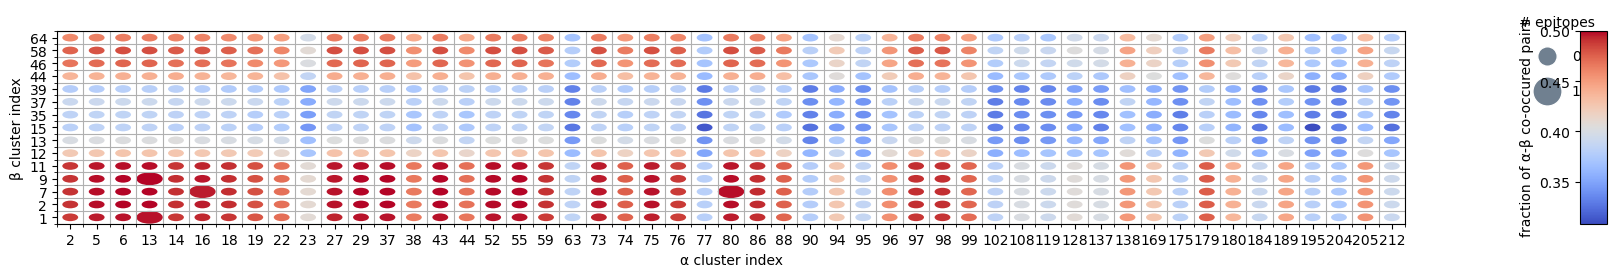

In [248]:
plot_cooccurence_heatmap_with_epitopes_labeling_bubble(
       cooccurence_df, 
       annot_df, 
       corr_threshold_row=np.quantile(cooccurence_df.to_numpy().flatten(), 0.97), 
       corr_threshold_col=np.quantile(cooccurence_df.to_numpy().flatten(), 0.97), 
       epitopes_count_threshold=0, 
       legend_x=1.15)

In [213]:
cooccurence_df.columns = pd.RangeIndex(0, 260)

In [153]:
annot_df.index

RangeIndex(start=0, stop=81, step=1)

In [150]:
annot_df.index =  pd.RangeIndex(0, 81)

In [214]:
cooccurence_df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,0.083732,0.082988,0.081673,0.077670,0.081340,0.081317,0.080769,0.079545,0.062500,0.074074,...,0.088235,0.028169,0.057851,0.061224,0.072848,0.041667,0.080153,0.060606,0.075758,0.084475
1,0.257812,0.293155,0.488210,0.254317,0.258594,0.495515,0.497371,0.158082,0.152952,0.202361,...,0.292975,0.057769,0.143116,0.062438,0.187285,0.102467,0.157473,0.107547,0.048290,0.271538
2,0.258915,0.293944,0.490405,0.255452,0.258915,0.498163,0.500000,0.158451,0.152482,0.200669,...,0.290801,0.057199,0.141831,0.061825,0.185690,0.101504,0.156966,0.106542,0.047809,0.270229
3,0.122449,0.140794,0.143123,0.123967,0.130612,0.140271,0.140288,0.098214,0.094512,0.090909,...,0.142336,0.074766,0.085987,0.063927,0.125668,0.071970,0.104790,0.077778,0.063725,0.127451
4,0.151292,0.163366,0.179965,0.151119,0.162362,0.177182,0.178694,0.131443,0.107895,0.136161,...,0.151667,0.030075,0.117486,0.051661,0.152582,0.094937,0.121762,0.099379,0.046875,0.161922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.108407,0.093023,0.110790,0.107623,0.097345,0.109653,0.109870,0.097315,0.062069,0.075419,...,0.101961,0.034091,0.094203,0.049724,0.113095,0.084071,0.104730,0.060345,0.036145,0.118644
77,0.160221,0.174629,0.179805,0.165736,0.169429,0.178756,0.179399,0.115681,0.131234,0.106904,...,0.156406,0.037453,0.108992,0.073529,0.128806,0.085174,0.121447,0.092879,0.046693,0.159858
78,0.096491,0.107692,0.110365,0.100000,0.092105,0.112045,0.113173,0.096026,0.088435,0.113260,...,0.108949,0.061111,0.085714,0.043243,0.088235,0.073913,0.093333,0.072034,0.047059,0.111345
79,0.096698,0.094262,0.087129,0.095694,0.096698,0.086622,0.086042,0.092593,0.072519,0.069697,...,0.080913,0.020270,0.076613,0.039216,0.090909,0.055556,0.085821,0.073529,0.043478,0.090090


In [215]:
cooccurence_df[cooccurence_df > np.quantile(cooccurence_df.to_numpy().flatten(), 0.95)]

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.488210,NaN,NaN,0.495515,0.497371,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.490405,NaN,NaN,0.498163,0.500000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
np.quantile(cooccurence_df.to_numpy().flatten(), 0.95)

0.0016399566348447349

(array([  35.,  121.,  320.,  792., 1140., 1424., 1553., 1300., 1376.,
        1288., 1205., 1155., 1043.,  897.,  731.,  696.,  584.,  430.,
         497.,  487.,  342.,  268.,  271.,  285.,  190.,  260.,  197.,
         185.,  158.,  185.,  130.,  152.,  191.,  162.,  104.,  113.,
         145.,   66.,  127.,   56.,   50.,   13.,   42.,   22.,   30.,
          31.,   43.,   47.,   26.,   95.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
 <BarContainer object of 50 artists>)

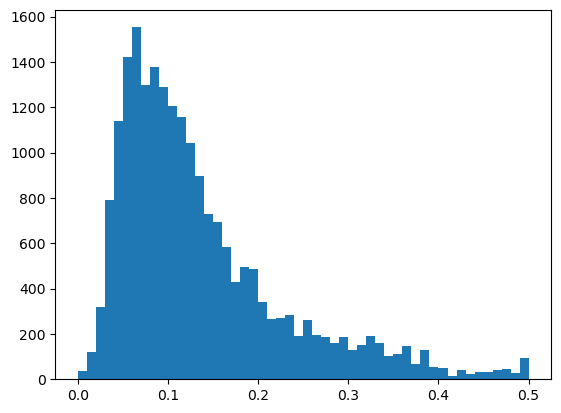

In [216]:
plt.hist(cooccurence_df.to_numpy().flatten(), bins=50)

In [165]:
annot_df.columns

RangeIndex(start=0, stop=260, step=1)

In [166]:
cooccurence_df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '250', '251', '252', '253', '254', '255', '256', '257', '258', '259'],
      dtype='object', length=260)

In [205]:
pd.read_csv('data/covid_significant_clone_pvals_adaptive.csv')

,Unnamed: 0,clone,pval
0,0,CAAAADSNQPQHF,1.0
1,1,CAAAAGNQPQHF,1.0
2,2,CAAAANTEAFF,1.0
3,3,CAAAANTGELFF,1.0
4,4,CAAAANYGYTF,1.0
...,...,...,...
5705367,5705367,YSYEQYF,1.0
5705368,5705368,YTEAFF,1.0
5705369,5705369,YTF,1.0
5705370,5705370,YYEQYF,1.0


In [207]:
pd.read_csv('data/clone_matrix_adaptive_top_500k.csv', nrows=10)

,cdr3aa
0,CAAAADSNQPQHF
1,CAAAAGNQPQHF
2,CAAAANTEAFF
3,CAAAANTGELFF
4,CAAAANYGYTF
5,CAAAASGANVLTF
6,CAAAASYEQYF
7,CAAAATNEKLFF
8,CAAAAYNEQFF
9,CAAADQETQYF
